In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
import segmentation_models_pytorch as smp
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from torchvision.models import ResNet50_Weights

# =============================
# CONFIGURAÇÕES
# =============================
DATA_DIR = '../data/processed'
MODEL_DIR = '../models'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 4

# =============================
# DATASET
# =============================
class BloodCellDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images = sorted(glob(f"{images_path}/*/*"))
        self.masks = sorted(glob(f"{masks_path}/*/*"))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB').resize(IMAGE_SIZE)
        mask = Image.open(self.masks[idx]).convert('L').resize(IMAGE_SIZE)

        if self.transform:
            image = self.transform(image)

        mask = np.array(mask, dtype=np.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        label_str = os.path.basename(os.path.dirname(self.images[idx]))
        label = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}[label_str]
        label = torch.tensor(label, dtype=torch.long)

        return image, mask, label

# =============================
# TRANSFORMAÇÕES
# =============================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# =============================
# DATALOADER
# =============================
val_dataset = BloodCellDataset(
    images_path=f'{DATA_DIR}/images/val',
    masks_path=f'{DATA_DIR}/masks/val',
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# =============================
# MODELOS
# =============================

# Segmentação
seg_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)
seg_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_segmentation_model.pth')))
seg_model.eval()

# Classificação
clf_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
clf_model.fc = nn.Linear(clf_model.fc.in_features, NUM_CLASSES)
clf_model = clf_model.to(DEVICE)
clf_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_classification_model.pth')))
clf_model.eval()

# =============================
# AVALIAÇÃO
# =============================
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()
clf_criterion = nn.CrossEntropyLoss()

def seg_loss_fn(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

total_seg_loss = 0
total_clf_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, masks, labels in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        labels = labels.to(DEVICE)

        # Segmentação
        seg_outputs = seg_model(images).squeeze(1)
        seg_loss = seg_loss_fn(seg_outputs, masks.squeeze(1))
        total_seg_loss += seg_loss.item()

        # Classificação
        clf_outputs = clf_model(images)
        clf_loss = clf_criterion(clf_outputs, labels)
        total_clf_loss += clf_loss.item()

        _, preds = torch.max(clf_outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_seg_loss = total_seg_loss / len(val_loader)
avg_clf_loss = total_clf_loss / len(val_loader)
accuracy = correct / total * 100

print(f"Avaliação:")
print(f" - Segmentação - Loss médio: {avg_seg_loss:.4f}")
print(f" - Classificação - Loss médio: {avg_clf_loss:.4f} | Acurácia: {accuracy:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\felip/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 82.4MB/s]


📊 Avaliação:
 - Segmentação - Loss médio: 0.1990
 - Classificação - Loss médio: 0.0002 | Acurácia: 100.00%


📈 Relatório de Classificação:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1123
           1     1.0000    1.0000    1.0000      1117
           2     1.0000    1.0000    1.0000      1115
           3     1.0000    1.0000    1.0000      1124

    accuracy                         1.0000      4479
   macro avg     1.0000    1.0000    1.0000      4479
weighted avg     1.0000    1.0000    1.0000      4479



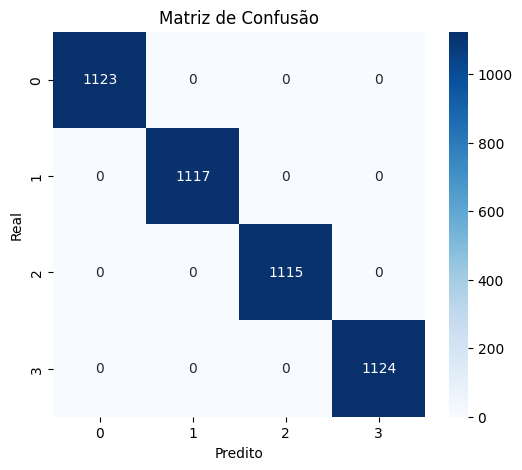

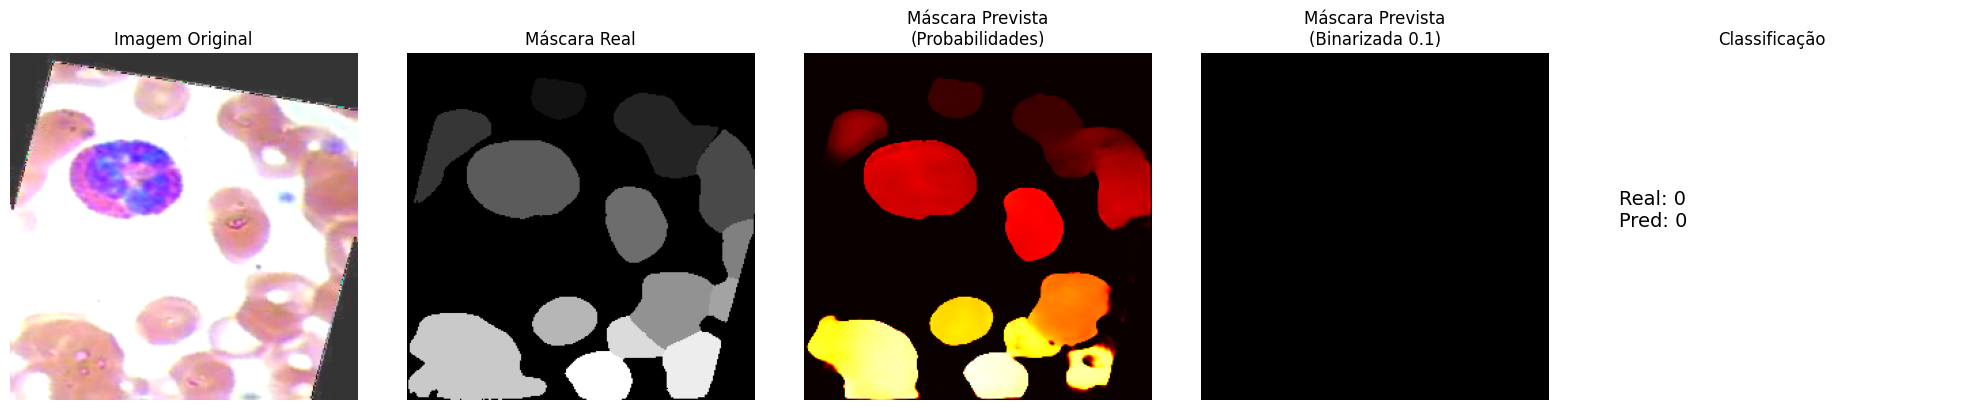

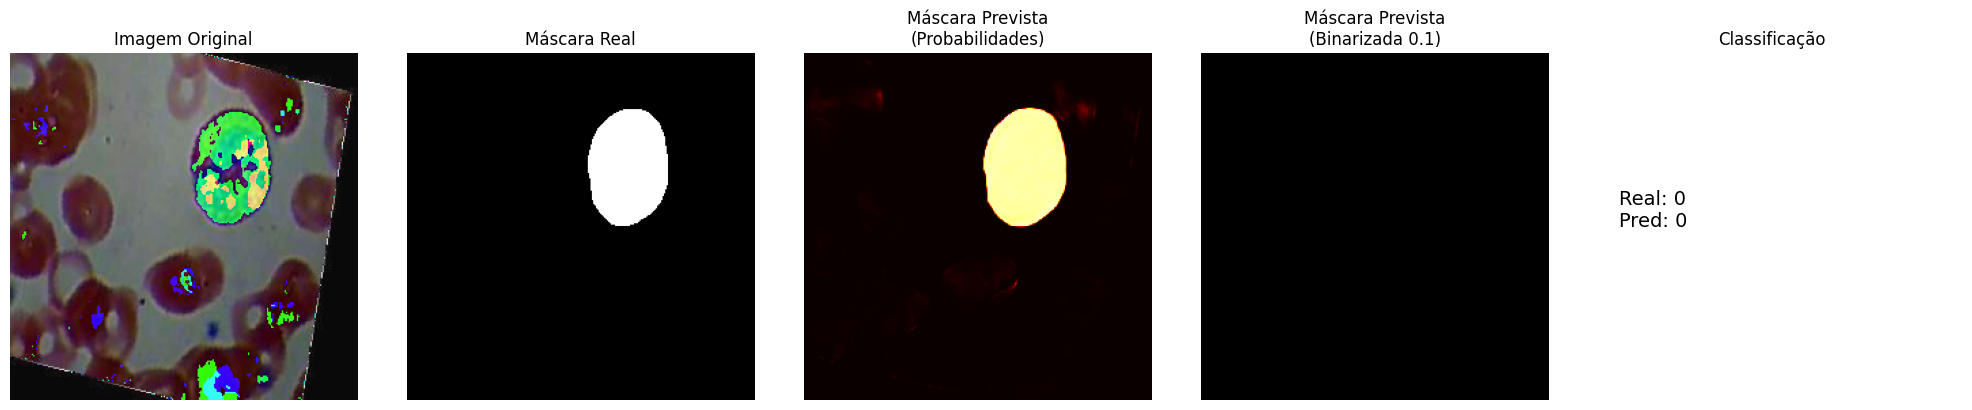

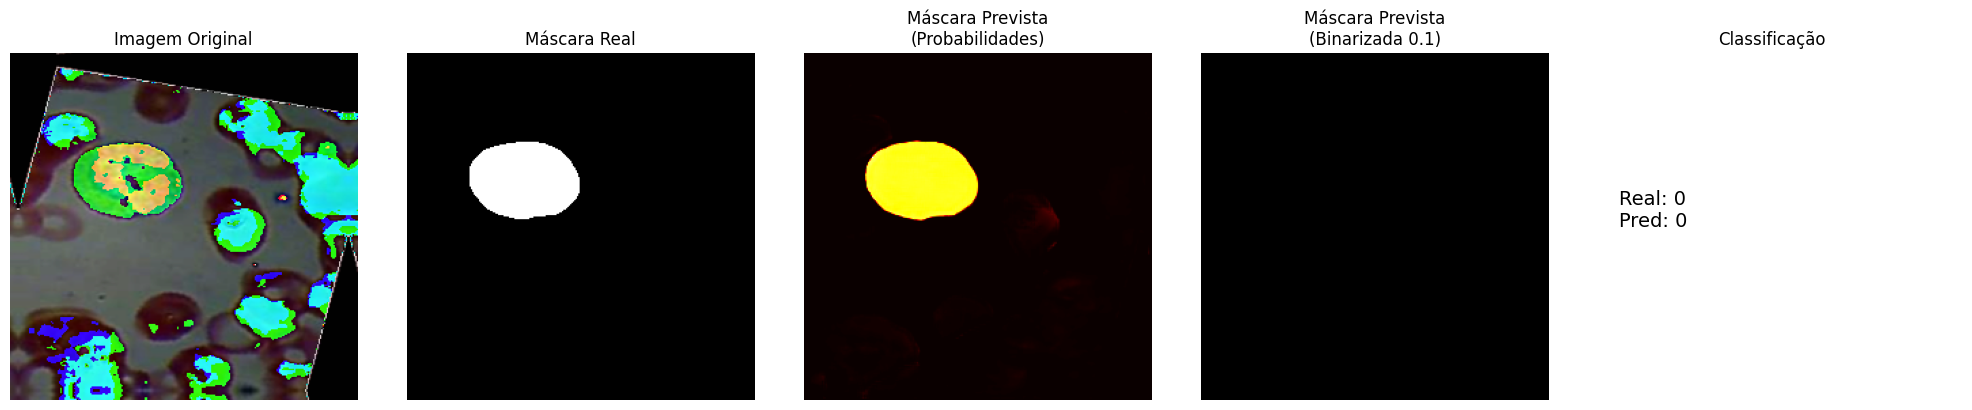

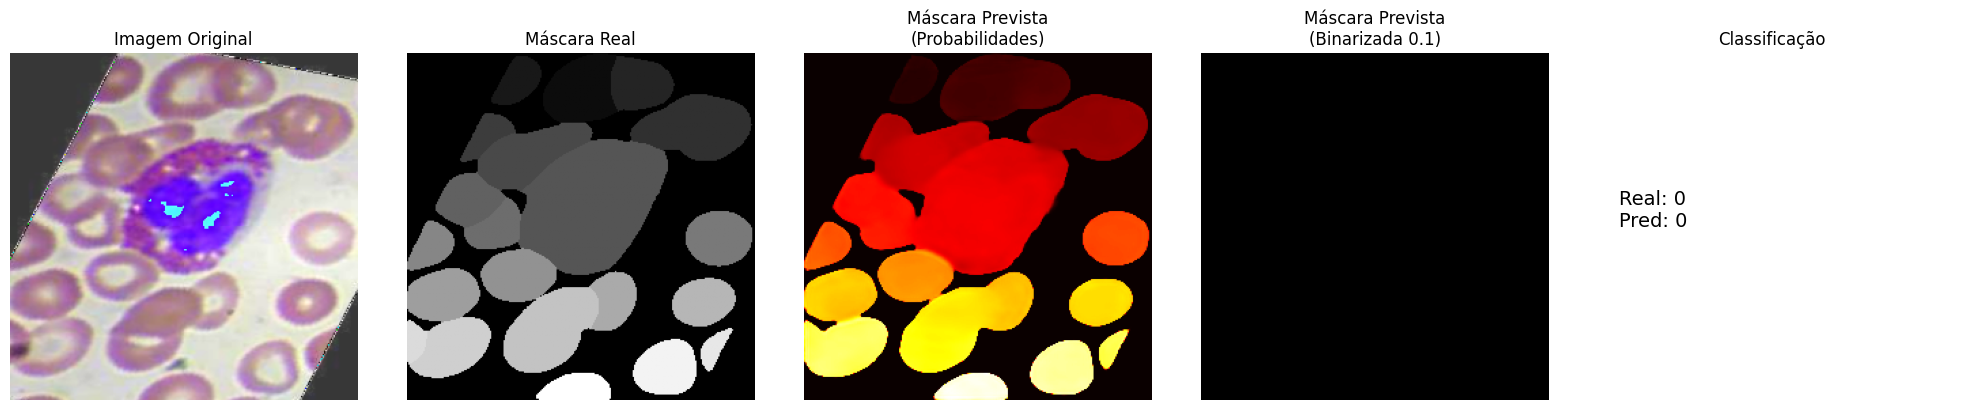

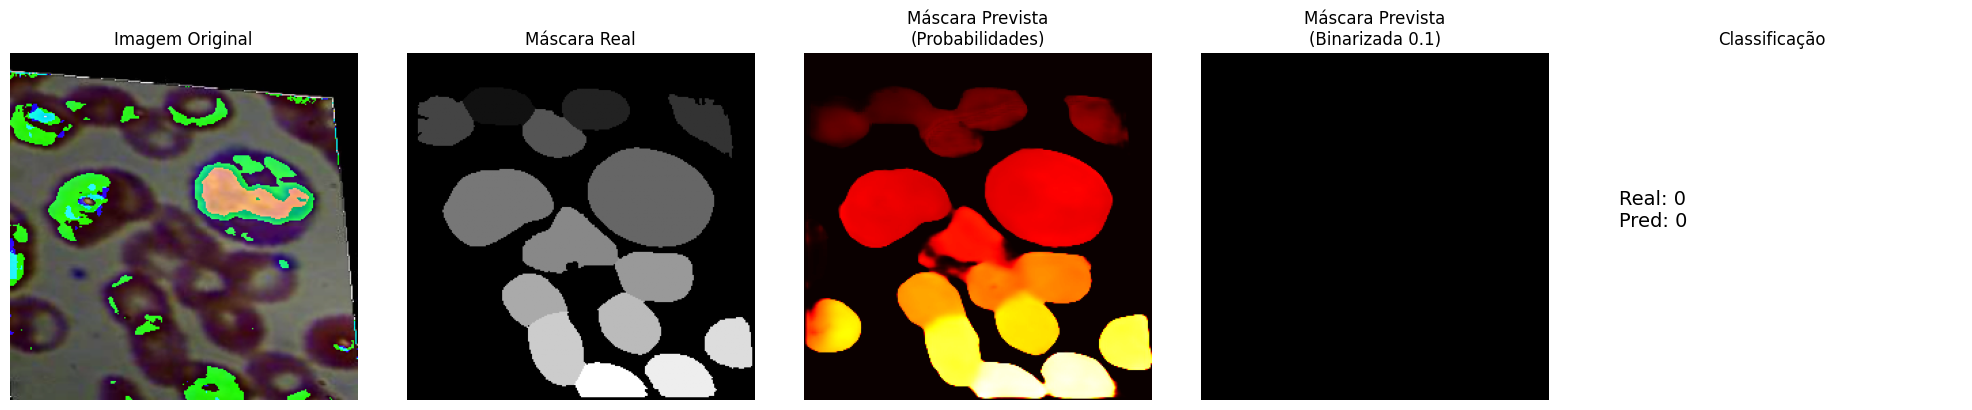

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

device = DEVICE 

seg_model.load_state_dict(torch.load(f'{MODEL_DIR}/best_segmentation_model.pth', map_location=device))
clf_model.load_state_dict(torch.load(f'{MODEL_DIR}/best_classification_model.pth', map_location=device))
seg_model.eval()
clf_model.eval()

threshold = 0.1 

def show_sample(img, mask_true, mask_pred_prob, mask_pred_bin, label_true, label_pred, threshold):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(TF.to_pil_image(img.cpu()))
    axs[0].set_title("Imagem Original")
    axs[0].axis('off')
    
    axs[1].imshow(mask_true.cpu().squeeze(), cmap='gray')
    axs[1].set_title("Máscara Real")
    axs[1].axis('off')

    axs[2].imshow(mask_pred_prob.squeeze(0).cpu(), cmap='hot')
    axs[2].set_title(f"Máscara Prevista\n(Probabilidades)")
    axs[2].axis('off')

    axs[3].imshow(mask_pred_bin.cpu().squeeze(), cmap='gray')
    axs[3].set_title(f"Máscara Prevista\n(Binarizada {threshold})")
    axs[3].axis('off')

    axs[4].text(0.1, 0.5, f"Real: {label_true}\nPred: {label_pred}",
                fontsize=14)
    axs[4].axis("off")
    axs[4].set_title("Classificação")

    plt.tight_layout()
    plt.show()

all_labels = []
all_preds = []

n_visual = 5
visual_samples = []

with torch.no_grad():
    for batch_idx, (images, masks, labels) in enumerate(val_loader):
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        # Predição segmentação
        seg_outputs = seg_model(images)        # saída: (batch, 1, H, W)
        seg_probs = torch.sigmoid(seg_outputs) # probs

        # Binarização das máscaras
        seg_preds_bin = (seg_probs > threshold).float()

        # Predição classificação
        clf_outputs = clf_model(images)
        clf_preds = torch.argmax(clf_outputs, dim=1)

        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(clf_preds.cpu().tolist())

        # Armazena algumas amostras para visualização
        if len(visual_samples) < n_visual:
            for i in range(images.size(0)):
                if len(visual_samples) >= n_visual:
                    break
                visual_samples.append((
                    images[i].cpu(),
                    masks[i].cpu(),
                    seg_probs[i].cpu(),
                    seg_preds_bin[i].cpu(),
                    labels[i].item(),
                    clf_preds[i].item()
                ))

print("📈 Relatório de Classificação:")
print(classification_report(all_labels, all_preds, digits=4))

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

for img, mask_true, mask_pred_prob, mask_pred_bin, label_true, label_pred in visual_samples:
    show_sample(img, mask_true, mask_pred_prob, mask_pred_bin, label_true, label_pred, threshold)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Relatório de Classificação:")
print(classification_report(all_labels, all_preds, digits=4))

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
